<a href="https://colab.research.google.com/github/SereniT33/Omdena_Disaster_response_ai/blob/main/Extract_openbuilding_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
As the first part of ETL process, this notebook **extracts** Google Open Building datasets for Indonesia and prepare the raw datasets before data transformation. It also showcases preliminary data visualization as a form of exploratory spatial analysis.

# Setup

In [2]:
!pip install geopandas
!pip install matplotlib

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import random
import gzip
from tqdm import tqdm
from shapely import wkt
import csv

# Data
Google Open Building dataset can be found and downloaded at: https://sites.research.google/open-buildings/

For a easier data access, I chose to download region-specific datasets, upload them on a personal Google Drive, then access them by mounting the Drive.

### (Optional) Mounting Google Drive for data access

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Extraction
For Indonesia, there are four different gzipped CSV files. I will declare them as *all_files*.

In [5]:
all_files = ['/content/gdrive/MyDrive/DataDive/indonesia1.csv.gz',
              '/content/gdrive/MyDrive/DataDive/indonesia2.csv.gz',
              '/content/gdrive/MyDrive/DataDive/indonesia3.csv.gz',
              '/content/gdrive/MyDrive/DataDive/indonesia4.csv.gz']

According to the function below created to count the rows, gzipped CSV files originally have more than 10 million rows.

In [5]:
# Count the rows
def numrows_from_csv_gz(filename : str) -> pd.DataFrame:
    # Determine the total number of rows in the file
    with gzip.open(filename, "rt") as f:
      total_rows = sum(1 for row in tqdm(f, desc="Counting rows"))
      return total_rows

for file in all_files:
  numrows_from_csv_gz(file)

Counting rows: 122475it [00:00, 186603.49it/s]


KeyboardInterrupt: ignored

As these files are too large to process on notebooks, I will use the following **data preparation strategy** to create a dataframe:
1. *filter* the rows with confidence level that is equal or greater than 0.85; and
2. randomly *sample* the rows with the sample size of 5%

### Filter the rows with high confidence threshold
As the Open Buildings data is subject to both omission and commission errors, it is recommended to choose the confidence score threshold at which buildings are filtered out.

This notebook chooses to use the confidence score threshold of 0.85 and append the resulting filtered rows into a dataframe, *filtered_df*. The filtered_df has more than 2 million rows.

In [ ]:
# Create an empty list to store filtered rows
filtered_rows = []

# Specify the column name to filter on
filter_column = 'confidence'

# Filter rows in gzipped CSV files without decompressing them
for file_path in all_files:
  with gzip.open(file_path, 'rt') as gzipped_file:
    csv_reader = csv.DictReader(gzipped_file)

    for row in csv_reader:
      # Check if the 'confidence' column is present in the row
      if filter_column in row:
        # Convert the values in the 'confidence' column to a float and compare it
        if float(row[filter_column]) > 0.85: # confidence threshold can be adjusted
          #Append the filtered row to the list
          filtered_rows.append(row)

filtered_df = pd.DataFrame(filtered_rows)

In [ ]:
print(filtered_df.head())
print(len(filtered_df.index))

      latitude     longitude area_in_meters confidence  \
0  -3.72173743  115.56482292        58.9743     0.8706   
1  -1.23160266  116.94812387       149.6142     0.9089   
2  -3.43046918  116.00152544       104.3989     0.8679   
3  -1.35626313  116.70726497       100.1234     0.8739   
4  -0.32342997  117.42589564       530.1144     0.8931   

                                            geometry full_plus_code  
0  POLYGON((115.564873049464 -3.72171533420889, 1...  6P8Q7HH7+8W4F  
1  POLYGON((116.9481987 -1.2316321, 116.9481239 -...  6PCRQW9X+965X  
2  POLYGON((116.001599204798 -3.43046037599388, 1...  6P8RH292+RJ69  
3  POLYGON((116.707309059052 -1.35619955360401, 1...  6PCRJPV4+FWRF  
4  POLYGON((117.425884900228 -0.323552873310044, ...  6PFVMCGG+J9CW  
2717664


### Randomly sample the rows

The sample size used here is 5% of the filtered dataframe. The resulting dataframe, *sampled_df*, has over 100,000 rows.

In [ ]:
# Specify the sample size
sample_size = int(0.05*(len(filtered_df.index))) # size can be adjusted

# Use the sample method to randomly select rows from the dataframe
sampled_rows = filtered_df.sample(n=sample_size, random_state=42)

sampled_df = pd.DataFrame(sampled_rows)

In [ ]:
print(sampled_df.head())
print(len(sampled_df.index))

            latitude     longitude area_in_meters confidence  \
1114099  -4.06257989  121.88494657        97.1062     0.8864   
101701   -2.17830454  115.42298882       206.7359     0.8883   
2310901   2.93876801  113.12079098       292.3707     0.9232   
2627231  -2.71505941  107.63256973       110.0049     0.9059   
1710451  -1.61843905  119.30482852       173.5508     0.8740   

                                                  geometry full_plus_code  
1114099  POLYGON((121.884996387361 -4.06253437595418, 1...  6Q73WVPM+XX8V  
101701   POLYGON((115.423069003039 -2.17840492974731, 1...  6P9QRCCF+M5HW  
2310901  POLYGON((113.120835439772 2.93879565957814, 11...  6PJMW4QC+G83M  
2627231  POLYGON((107.632629564769 -2.71509432449062, 1...  6P997JMM+X2GJ  
1710451  POLYGON((119.304898259333 -1.61841087614697, 1...  6PCX98J3+JWGG  
135883


# Data Visualization



In [ ]:
!pip install basemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 19.9 MB/s eta 0:00:00


In [ ]:
sampled_df['latitude'] = pd.to_numeric(sampled_df['latitude'])
sampled_df['longitude'] = pd.to_numeric(sampled_df['longitude'])

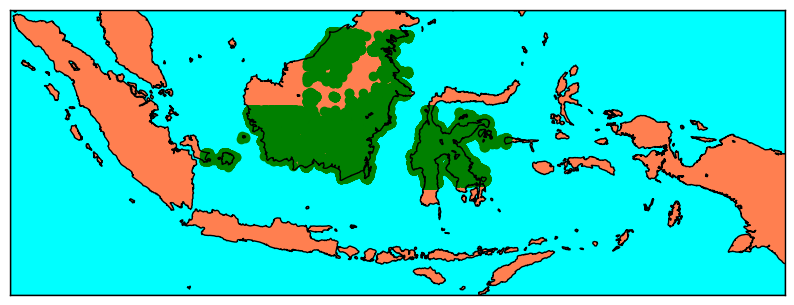

In [ ]:
from mpl_toolkits.basemap import Basemap

# Define the latitude and logitude boundaries of the map (Derived from: https://cartographyvectors.com/map/937-indonesia-detailed-boundary)
latitude1 = -10.9226   # latitude of the lower left corner
latitude2 = 5.9101  # latitude of the upper right corner
longitude1 = 95.0127   #longitude of the lower left corner
longitude2 = 140.9776  #longitude of upper right corner


# Create a Basemap centered on the specified location
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(projection='merc', llcrnrlat=latitude1, urcrnrlat=latitude2,
            llcrnrlon=longitude1, urcrnrlon=longitude2, resolution='i')
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')

# Scatter data points on the same map
x, y = m(sampled_df.longitude.values, sampled_df.latitude.values)
m.scatter(x, y, marker='o', color='green', label='Data Points')
plt.show()


Causes for concern
- when compared to population density maps, this data does not include densely populated areas such as Jakarta.

What could be the issue? How can we solve it?
- confidence theshold too high?
- bigger sample size

### Theory testing: lower confidence threshold (

In [6]:
# Confidence level = 0.65
# Create an empty list to store filtered rows
filtered_rows = []

# Specify the column name to filter on
filter_column = 'confidence'

# Filter rows in gzipped CSV files without decompressing them
for file_path in all_files:
  with gzip.open(file_path, 'rt') as gzipped_file:
    csv_reader = csv.DictReader(gzipped_file)

    for row in csv_reader:
      # Check if the 'confidence' column is present in the row
      if filter_column in row:
        # Convert the values in the 'confidence' column to a float and compare it
        if float(row[filter_column]) > 0.7: # confidence threshold adjusted to 0.7
          #Append the filtered row to the list
          filtered_rows.append(row)

filtered_df = pd.DataFrame(filtered_rows)

KeyboardInterrupt: ignored

In [ ]:
print(filtered_df.head())
print(len(filtered_df.index))

In [12]:
# Adjust the sample size = 10%
sample_size = int(0.1*(len(filtered_df.index))) # size adjusted

# Use the sample method to randomly select rows from the dataframe
sampled_rows = filtered_df.sample(n=sample_size, random_state=42)

sampled_df = pd.DataFrame(sampled_rows)

In [13]:
print(sampled_df.head())
print(len(sampled_df.index))

            latitude     longitude area_in_meters confidence  \
273813   -2.36837104  115.56636904        42.0597     0.8183   
7939264   3.58980216  116.63206939       359.3946     0.9344   
2188392  -3.74530772  115.48886886        92.4423     0.8797   
446169   -0.46443374  116.99304974       149.5566     0.7931   
5596761  -4.00179304  120.12041905        11.8169     0.7415   

                                                  geometry full_plus_code  
273813   POLYGON((115.566410618525 -2.36837837223176, 1...  6P9QJHJ8+MG55  
7939264  POLYGON((116.632183980896 3.58969887869581, 11...  6PMRHJQJ+WRG2  
2188392  POLYGON((115.488922805209 -3.74534162455115, 1...  6P8Q7F3Q+VGHQ  
446169   POLYGON((116.993131401727 -0.464398593188674, ...  6PFRGXPV+66FP  
5596761  POLYGON((120.120432424172 -4.00181103781486, 1...  6Q72X4XC+75M7  
975902


In [14]:
sampled_df['latitude'] = pd.to_numeric(sampled_df['latitude'])
sampled_df['longitude'] = pd.to_numeric(sampled_df['longitude'])

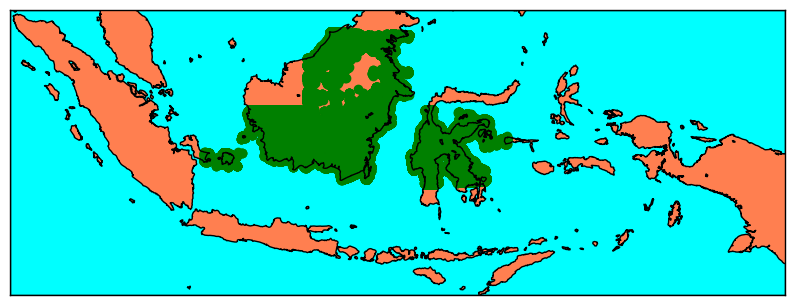

In [15]:
!pip install basemap
from mpl_toolkits.basemap import Basemap

# Define the latitude and logitude boundaries of the map (Derived from: https://cartographyvectors.com/map/937-indonesia-detailed-boundary)
latitude1 = -10.9226   # latitude of the lower left corner
latitude2 = 5.9101  # latitude of the upper right corner
longitude1 = 95.0127   #longitude of the lower left corner
longitude2 = 140.9776  #longitude of upper right corner


# Create a Basemap centered on the specified location
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(projection='merc', llcrnrlat=latitude1, urcrnrlat=latitude2,
            llcrnrlon=longitude1, urcrnrlon=longitude2, resolution='i')
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')

# Scatter data points on the same map
x, y = m(sampled_df.longitude.values, sampled_df.latitude.values)
m.scatter(x, y, marker='o', color='green', label='Data Points')
plt.show()


### Check the tile for Jakarta

In [4]:
# Check the tile for Jakarta specific
file_path_jkt = '/content/gdrive/MyDrive/DataDive/jakarta.gz'

In [5]:
import gzip
import csv

# Replace 'yourfile.gz' with the actual filename
input_file = file_path_jkt
output_csv_gz_file = 'output.csv.gz'

# Open the CSV.gz file for writing
with gzip.open(output_csv_gz_file, 'wt', newline='') as csv_gz_file:
    csv_writer = csv.writer(csv_gz_file)

    # Open the .gz file and read it line by line
    with gzip.open(input_file, 'rb') as gz_file:
        for line in gz_file:
            # Decode the line (assuming it's in utf-8 encoding)
            line = line.decode('utf-8')

            # Split the line into fields, assuming it's comma-separated
            fields = line.strip().split(',')

            # Process and manipulate the data as needed
            # For example, you can filter, modify, or validate the fields

            # Write the processed data to the CSV.gz file
            csv_writer.writerow(fields)

# Provide a download link for the resulting CSV.gz file
from google.colab import files
files.download(output_csv_gz_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# import gzip
# import csv

# # Replace 'yourfile.gz' with the actual filename
# input_file = file_path_jkt
# output_csv_file = 'output.csv.gz'

# # Open the CSV file for writing
# with open(output_csv_gz_file, 'wt', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)

#     # Open the .gz file and read it line by line
#     with gzip.open(input_file, 'rb') as gz_file:
#         for line in gz_file:
#             # Decode the line (assuming it's in utf-8 encoding)
#             line = line.decode('utf-8')

#             # Split the line into fields, assuming it's comma-separated
#             fields = line.strip().split(',')

#             # Process and manipulate the data as needed
#             # For example, you can filter, modify, or validate the fields

#             # Write the processed data to the CSV file
#             csv_writer.writerow(fields)

# # Provide a download link for the resulting CSV file
# from google.colab import files
# files.download(output_csv_file)


In [2]:
import gzip
# Define your filter condition (e.g., a function)
def filter_condition(row):
    # Filter confidence threshold > 0.85
    return float(row['confidence']) > 0.85

# Open the .gz file and read it line by line
filtered_data = []

with gzip.open(output_csv_gz_file, 'rt') as gz_file:
    csv_reader = csv.reader(gz_file)

    # Read and filter the header row (if present)
    header = next(csv_reader, None)

    if header:
        filtered_data.append(header)

    for row in csv_reader:
        # Check the filter condition for each row
        if filter_condition(row):
            filtered_data.append(row)

# Create a Pandas DataFrame from the filtered data
df = pd.DataFrame(filtered_data[1:], columns=filtered_data[0])

# Now you have the filtered data in a Pandas DataFrame

NameError: ignored

In [ ]:
# # Create an empty list to store filtered rows
# filtered_rows = []

# # Specify the column name to filter on
# filter_column = 'confidence'

# # Filter rows in gzipped CSV files without decompressing them
# # for file_path in all_files:
# with gzip.open(output_csv_gz_file, 'rt') as gzipped_file:
#     csv_reader = csv.DictReader(gzipped_file)

#     for row in csv_reader:
#       # Check if the 'confidence' column is present in the row
#       if filter_column in row:
#         # Convert the values in the 'confidence' column to a float and compare it
#         if float(row[filter_column]) > 0.85: # confidence threshold can be adjusted
#           #Append the filtered row to the list
#           filtered_rows.append(row)

# filtered_df = pd.DataFrame(filtered_rows)

In [ ]:
print(df.head())
print(len(df.index))

In [ ]:
# Specify the sample size
sample_size = int(0.05*(len(df.index))) # size can be adjusted

# Use the sample method to randomly select rows from the dataframe
sampled_rows = df.sample(n=sample_size, random_state=42)

sampled_df = pd.DataFrame(sampled_rows)

In [ ]:
print(sampled_df.head())
print(len(sampled_df.index))

In [ ]:
sampled_df['latitude'] = pd.to_numeric(sampled_df['latitude'])
sampled_df['longitude'] = pd.to_numeric(sampled_df['longitude'])

In [ ]:
from mpl_toolkits.basemap import Basemap

# Define the latitude and logitude boundaries of the map (Derived from: https://cartographyvectors.com/map/937-indonesia-detailed-boundary)
latitude1 = -10.9226   # latitude of the lower left corner
latitude2 = 5.9101  # latitude of the upper right corner
longitude1 = 95.0127   #longitude of the lower left corner
longitude2 = 140.9776  #longitude of upper right corner


# Create a Basemap centered on the specified location
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(projection='merc', llcrnrlat=latitude1, urcrnrlat=latitude2,
            llcrnrlon=longitude1, urcrnrlon=longitude2, resolution='i')
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral', lake_color='aqua')

# Scatter data points on the same map
x, y = m(sampled_df.longitude.values, sampled_df.latitude.values)
m.scatter(x, y, marker='o', color='green', label='Data Points')
plt.show()
